<footer id="attribution" style="float:right; color:#999">
Created by Thibault Dody, 05/11/2020.
</footer>

<figure>
<img src="../app/static/oil-paint-banner.jpg" style="width:1920px;">
</figure>

# Models

## Table of Content

1. Import Modules and Libraries
2. Import Dataset
3. Set Directory Structure¶
4. Data Cleaning
5. Data Exploration

## Import Modules and Libraries

In [1]:
import os, sys
sys.path.append('..')

%matplotlib inline
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import seaborn as sns
sns.set_style("darkgrid")
sns.set(font_scale = 1.5)

from sklearn.model_selection import train_test_split

import StyleYourArt
from StyleYourArt.dataloader import *
from StyleYourArt.tools import *
from StyleYourArt.models import *

Using TensorFlow backend.


## Import Dataset

In [2]:
## Locations
DATA_DIR = '../data/csv/'
IMAGE_DIR = '../data/images/'
SAVED_DIR = '../data/classes'

In a previous notebook, we built a module to load and clear the data. The code can be found in `dataloader.py`.

In [3]:
## extract data from csv file
df = load_clean_data(DATA_DIR, IMAGE_DIR, verbose=True)

... loading painting data from master.csv
... painting data imported from master.csv
... setting dataframe schema
... exporting unique styles to styles.csv
... data loaded
... finding top 25 most popular styles
... filtering data.
   ... record count before filtering: 169677
   ... record count after filtering: 117050
... replace missing values


In [4]:
## display dataset info
print_data_info(df)

******************* SUMMARY *******************

Content
-----------------------------------------------
Rows: 117,050
Cols: 14
Number of artists: 2,434
Number of unique styles: 18
Date range: from 1401 to 2020


Info
-----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 117050 entries, 3 to 19
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   artist_name      117050 non-null  object 
 1   artist_url       117050 non-null  object 
 2   completion_year  90570 non-null   float64
 3   content_id       117050 non-null  int64  
 4   height           117050 non-null  int64  
 5   image            117050 non-null  object 
 6   json_file        117050 non-null  object 
 7   style            117050 non-null  object 
 8   title            117050 non-null  object 
 9   url              117050 non-null  object 
 10  width            117050 non-null  int64  
 11  format     

In [5]:
## display a few records
df.head(5)

artist_name artist_url  completion_year           content_id  height  \
3  MISHRA ANIRBAN   a-mishra              NaN  9223372032559846598    3354   
4  MISHRA ANIRBAN   a-mishra              NaN  9223372032559846599    3354   
5  MISHRA ANIRBAN   a-mishra              NaN  9223372032559846600    3656   
6  MISHRA ANIRBAN   a-mishra              NaN  9223372032559846597    3278   
7  MISHRA ANIRBAN   a-mishra              NaN  9223372032559846454    3800   

                                               image      json_file  \
3  https://uploads7.wikiart.org/00272/images/a-mi...  a-mishra.json   
4  https://uploads5.wikiart.org/00272/images/a-mi...  a-mishra.json   
5  https://uploads2.wikiart.org/00272/images/a-mi...  a-mishra.json   
6  https://uploads0.wikiart.org/00272/images/a-mi...  a-mishra.json   
7  https://uploads4.wikiart.org/00272/images/a-mi...  a-mishra.json   

            style                       title                       url  \
3  Conceptual Art                      Vision                    vision   
4  Conceptual Art                        Time                      time   
5  Conceptual Art       Persistence of memory     persistence-of-memory   
6  Conceptual Art                Conversation              conversation   
7    Abstract Art  Expression of sadness - II  expression-of-sadness-ii   

   width format                                           file_loc  \
3   3559    jpg  ../data/images/a-mishra/unknown-year/922337203...   
4   3559    jpg  ../data/images/a-mishra/unknown-year/922337203...   
5   3440    jpg  ../data/images/a-mishra/unknown-year/922337203...   
6   3511    jpg  ../data/images/a-mishra/unknown-year/922337203...   
7   4665    jpg  ../data/images/a-mishra/unknown-year/922337203...   

   image_exists  
3          True  
4          True  
5          True  
6          True  
7          True

In [6]:
df_order = df[['completion_year', 'style']]
df_order = pd.DataFrame(df_order.groupby('style').quantile(0.02)['completion_year'].sort_values()).reset_index()
df_order = pd.merge(df[['completion_year', 'style']], df_order, on="style")
df_order = df_order.sort_values(by='completion_year_y')
df_order = df_order.rename(columns={"completion_year_x": "Year"})

## Set Directory Structure

Keras can use the directory structure to determine the image classes. To do so, we need to store each image into a folder titled with the painting style.  
A python function `organize_directories` in module `models.py` is used to move each picture in its corresponding style directory. Note that the images are also resized as **224x224** and saved as **png**. Finally, the distribution is done by splitting the dataset into a train and test sets. The split is done by stratifying the styles and assigning randomly **20%** of each styles into the test set.


In [7]:
!tree ../data/classes -L 1

../data/classes
├── test
└── train

2 directories, 0 files


In [8]:
!tree ../data/classes/train -L 1

../data/classes/train
├── Abstract\ Art
├── Art\ Nouveau\ (Modern)
├── Baroque
├── Conceptual\ Art
├── Cubism
├── Expressionism
├── Impressionism
├── Minimalism
├── Naïve\ Art\ (Primitivism)
├── Neo-Expressionism
├── Neoclassicism
├── Pop\ Art
├── Realism
├── Renaissance
├── Romanticism
├── Surrealism
├── Symbolism
└── Ukiyo-e

18 directories, 0 files


In [9]:
## repeat split
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['style'])

## disconnect train and test from original dataset
X_train = X_train.copy()
X_test = X_test.copy()

In [10]:
## create a new feature corresponding to the final locations
X_train['save_dir'] = SAVED_DIR + '/train/' + X_train['style'] + '/' + X_train['content_id'].astype(str) + '.png'
X_test['save_dir'] = SAVED_DIR + '/test/' + X_test['style'] + '/' + X_test['content_id'].astype(str) + '.png'

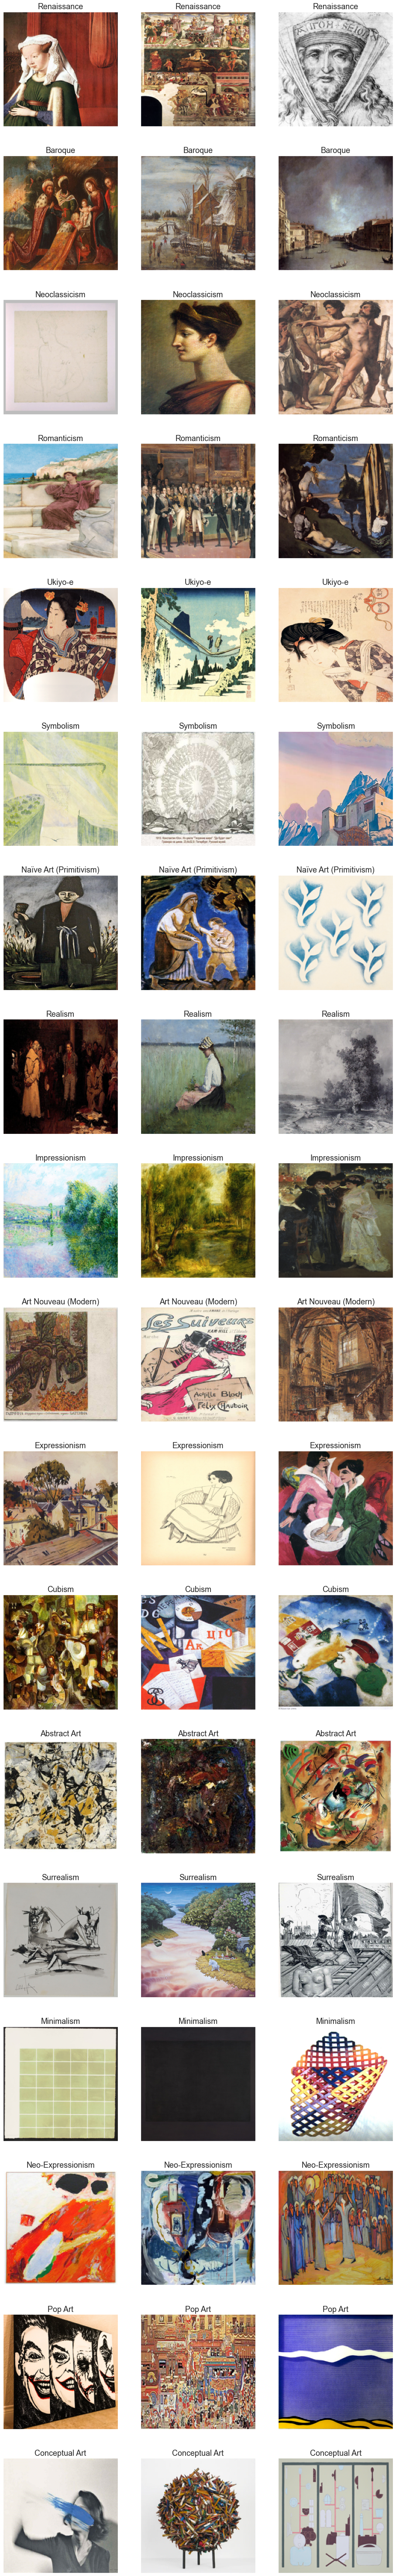

<Figure size 432x288 with 0 Axes>

In [11]:
## display examples of the resized images
%matplotlib inline
display_images(X_train, list(df_order['style'].unique()), dir_feature='save_dir')
plt.tight_layout()
plt.show();

In [12]:
## compbine both sets into a unique dataset
X_train['set'] = 'Train'
X_test['set'] = 'Test'
df_full = pd.concat([X_train, X_test])

In [13]:
## compute class weights
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(X_train['style']),
                                                  X_train['style'])
weights = pd.Series(dict(zip(np.unique(X_train['style']),class_weights))).sort_values(ascending=False)

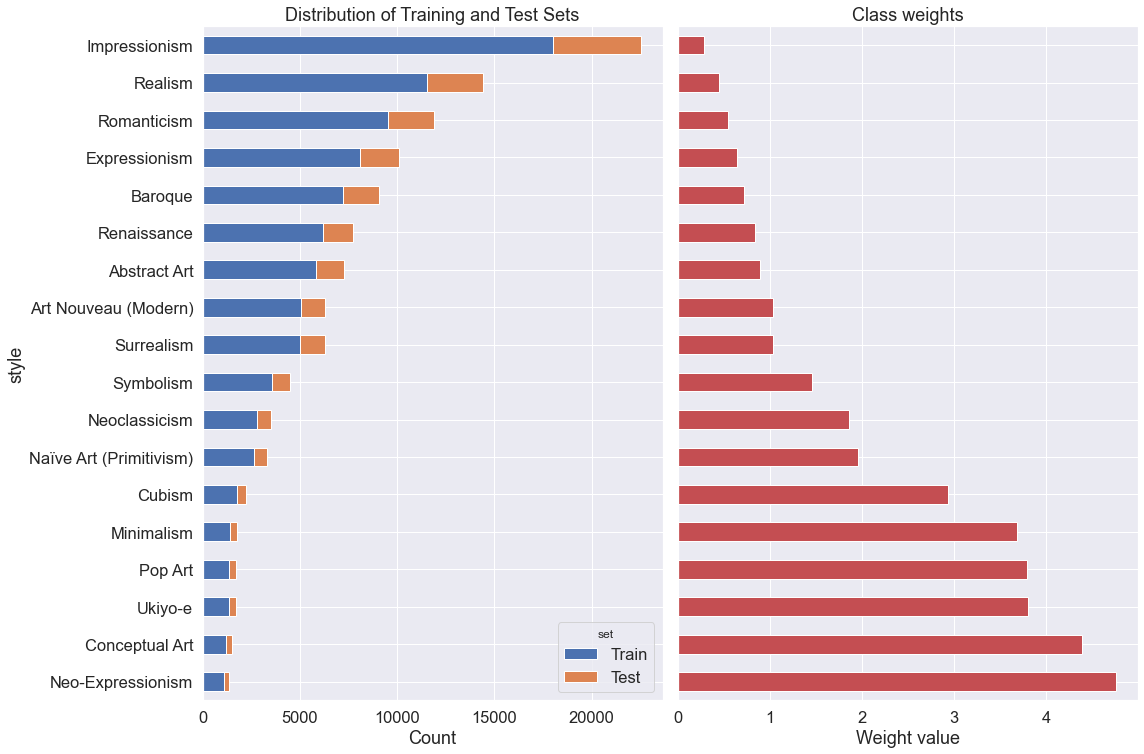

In [14]:
## compute distribution
%matplotlib inline
df_plot = df_full.groupby(['set', 'style']).size().reset_index().pivot(columns='set', index='style', values=0).sort_values(['Train'], ascending=True)
df_plot = df_plot[['Train', 'Test']]

## plot style distribution
fig, axes = plt.subplots(1,2,figsize=(16,10), sharey=True)
df_plot.plot(kind='barh', stacked=True, ax=axes[0])
weights.plot(kind='barh', ax=axes[1], color='r')
plt.tight_layout()
axes[0].set_title("Distribution of Training and Test Sets")
axes[1].set_title("Class weights")
axes[0].set_xlabel("Count")
axes[1].set_xlabel("Weight value")
plt.show();

As shown above, the dataset has been divided into the train and test set while maintaining the class proportion. In order to avoid bias over class that are overly represented (Impressionism, Realism...). The metrics of interest will be weighted so that each class is assigned the same importance.

## Convolutional Neural Network
In this section, we will train a CNN to predict the species feature. The approach is divided between the following steps:

- Encode the target feature
- Download the data
- Split the data between a training and test set
- Perform data augmentation
- Determine the cost function to be optimized
- Data Loader, Validation and Data Augmentation

In order for our model to generalize well on unseen data, a good practice consists of using image transformation to create new unseen examples.
We need to ensure that our model does not over fit the training data. To do so, we are using a training set and a test set both taken from the original dataset.

Keras contains useful tools to help process image files and feed them in batches to the model. We will be using a generator for both the train and test phases.

First, we must create a new feature to our dataset which contains the full path to each image.
Then, we can create two generators, the training generator will contains several data augmentation transformation (horizontal and vertical flips, zoom).
Both the train and test generator will normalize the pixel values.
Finally, the images will be sent to the model using batches of 16 RGB images reshaped at 224x224.

### Transfer Learning - First Generation  
Before we train a model on the entire dataset, we need to investigate the following modeling choices:
1. Architecture
2. Optimization metrics
3. Callbacks
4. Optimizers 

During this initial phase, we will test 5 different base models using only 1,000 images per class. The considered base models are:
- ResNet50
- Inception V3
- MobileNet V2
- Xception
- VGG16

For each model, we remove the top layer and add a custom model to it. This top model is defined as follows:
- Conv2D (512, 2, relu)
- Flatten
- Dense (2048, relu)
- Dense (1024, relu)
- Dense (512, relu)
- Dense (256, relu)
- Dense (64, relu)
- Dense (18, softmax)

In [15]:
## load results
results = pd.read_csv('../data/training_phase1.csv')
results['size_total_MB'] = results['size_base_MB'] + results['size_top_MB']
results

model          tag  val_loss  val_accuracy      loss  accuracy  \
0  1.a.1000     ResNet50  2.512670      0.208333  2.610792  0.181167   
1  1.b.1000        VGG16  1.930195      0.373611  1.895698  0.385111   
2  1.c.1000  InceptionV3  1.890462      0.391667  1.687830  0.453889   
3  1.d.1000  MobileNetV2  1.745986      0.436389  1.514181  0.501667   
4  1.e.1000     Xception  1.799670      0.419722  1.740675  0.439667   

   size_base_MB  size_top_MB  size_total_MB  
0          94.7        131.6          226.3  
1          58.9        106.5          165.4  
2          87.9         89.7          177.6  
3           9.4        119.0          128.4  
4          83.7        131.6          215.3

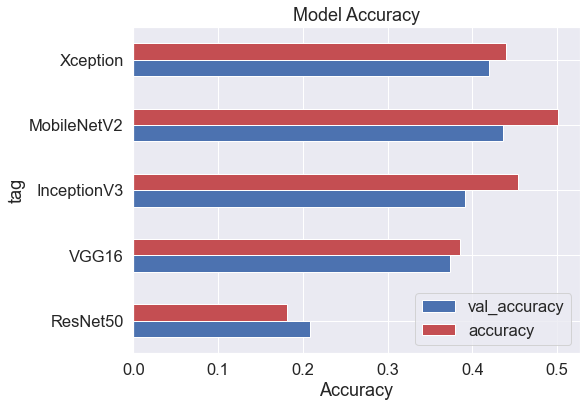

In [16]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,6))
results[['tag', 'val_accuracy', 'accuracy']].set_index('tag').plot(ax=ax, kind='barh', color=['b','r'])
ax.set_title("Model Accuracy")
ax.set_xlabel('Accuracy')
plt.show();

The MobileNet V2 seems to be the best choice, it scores the highest in term of validation accuracy and is also the lightest model (128M). However, this weight is still a bit much to easily deploy on a Heroku instance. We make a new version of the top model by decreasing the size of the top model first dense layer from 2048 neurons to 1024.

### Transfer Learning - Second Generation  

#### Architecture - MobileNet V2

<figure>
<img src="../app/static/MobileNetV2.png" style="width:500px;">
</figure>

- There are 3 layers for both types of blocks.
- The first layer is 1×1 convolution with ReLU6.
- The second layer is the depthwise convolution.
- The third layer is another 1×1 convolution but without any non-linearity. It is claimed that if ReLU is used again, the deep networks only have the power of a linear classifier on the non-zero volume part of the output domain.

<figure>
<img src="../app/static/MobileNetV2_structure.png" style="width:400px;">
</figure>

<figure>
<img src="../app/static/MobileNetV2_overall.png" style="width:350px;">
</figure>

where:
- t: expansion factor
- c: number of output channels
- n: repeating number
- s: stride.
- 3×3 kernels are used for spatial convolution.  

This top model is defined as follows:
- Conv2D (512, 2, relu)
- Flatten
- Dense (1024, relu)
- Dense (1024, relu)
- Dense (512, relu)
- Dense (256, relu)
- Dense (64, relu)
- Dense (18, softmax)

#### Results

**Training**
<figure>
<img src="../models/1.d.1000/history.png" style="width:1920px;">
</figure>

**Training**
<table>
    <tr>
        <td>
<figure>
    <img src="../models/1.d.1000/Train_Set_AUC_ROC.png" style="width:600px;"></figure></td>
        <td>
            <figure>
    <img src="../models/1.d.1000/Test_Set_AUC_ROC.png" style="width:600px;"></figure>
        </td>
    </tr>
    </table>

**Predictions**
<table>
    <tr>
        <td>
<figure>
    <img src="../models/1.d.1000/Train_Set_confusion_matrix.png"></figure></td>
        <td>
            <figure>
    <img src="../models/1.d.1000/Train_Set_Normalize_confusion_matrix.png"></figure>
        </td>
    </tr>
    </table>

<table>
    <tr>
        <td>
<figure>
    <img src="../models/1.d.1000/Test_Set_confusion_matrix.png"></figure></td>
        <td>
            <figure>
    <img src="../models/1.d.1000/Test_Set_Normalize_confusion_matrix.png"></figure>
        </td>
    </tr>
    </table>

In [73]:
## load prediction reports
train_report = pd.read_csv("../models/1.d.1000/Train_Set_report.csv", index_col=0)[['precision', 'recall', 'f1-score']]
test_report = pd.read_csv("../models/1.d.1000/Test_Set_report.csv", index_col=0)[['precision', 'recall', 'f1-score']]

train_report = train_report.iloc[0:-3,:]
test_report = test_report.iloc[0:-3,:]

report = pd.merge(left=train_report, right=test_report, left_index=True, right_index=True, suffixes=('_train', '_test'))

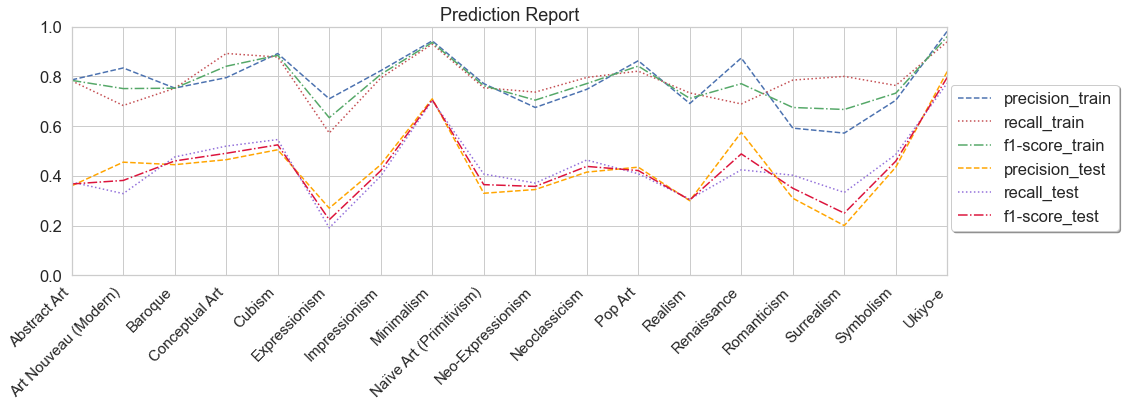

In [127]:
## plot report
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(16,6))
report.plot(ax=ax, style=['--',':','-.','--',':','-.'], color=['b','r','g', 'orange', 'mediumpurple', 'crimson'])

ax.set_xticks(range(0,18)) 
ax.set_xticklabels(report.index, fontsize=15)
plt.xticks(rotation=45, ha = 'right')

ax.legend(loc='upper center', bbox_to_anchor=(1.1, 0.8),fancybox=True, shadow=True, ncol=1)
ax.set_title("Prediction Report")
ax.set_ylim(0, 1.)
ax.set_xlim(0, 17)
plt.tight_layout();

### Transfer Learning - Third Generation  

**Training**
<figure>
<img src="../models/2_d/history.png" style="width:1920px;">
</figure>

**Training**
<table>
    <tr>
        <td>
<figure>
    <img src="../models/2_d/Train_Set_AUC_ROC.png" style="width:600px;"></figure></td>
        <td>
            <figure>
    <img src="../models/2_d/Test_Set_AUC_ROC.png" style="width:600px;"></figure>
        </td>
    </tr>
    </table>

**Predictions**
<table>
    <tr>
        <td>
<figure>
    <img src="../models/2_d/Train_Set_confusion_matrix.png"></figure></td>
        <td>
            <figure>
    <img src="../models/2_d/Train_Set_Normalize_confusion_matrix.png"></figure>
        </td>
    </tr>
    </table>

<table>
    <tr>
        <td>
<figure>
    <img src="../models/2_d/Test_Set_confusion_matrix.png"></figure></td>
        <td>
            <figure>
    <img src="../models/2_d/Test_Set_Normalize_confusion_matrix.png"></figure>
        </td>
    </tr>
    </table>

In [163]:
## load prediction reports
train_report = pd.read_csv("../models/2_d/Train_Set_report.csv", index_col=0)[['precision', 'recall', 'f1-score']]
test_report = pd.read_csv("../models/2_d/Test_Set_report.csv", index_col=0)[['precision', 'recall', 'f1-score']]

train_report = train_report.iloc[0:-3,:]
test_report = test_report.iloc[0:-3,:]

report = pd.merge(left=train_report, right=test_report, left_index=True, right_index=True, suffixes=('_train', '_test'))

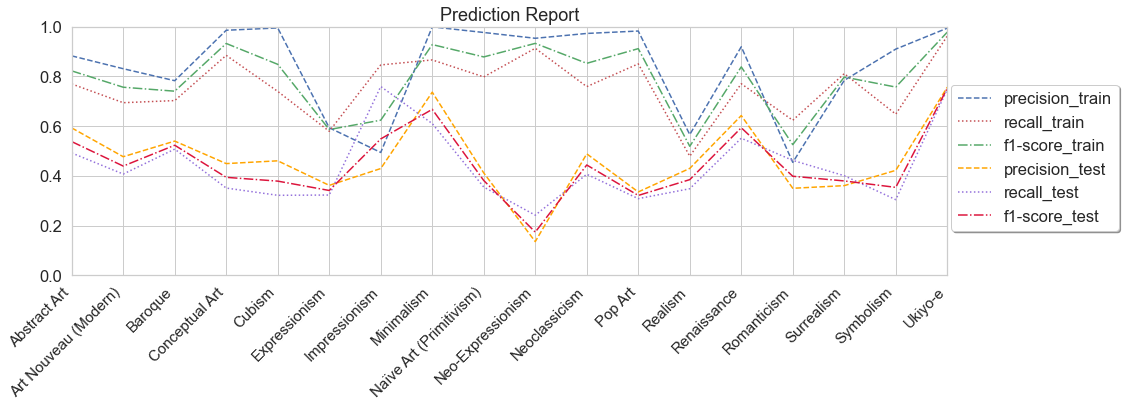

In [164]:
## plot report
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(16,6))
report.plot(ax=ax, style=['--',':','-.','--',':','-.'], color=['b','r','g', 'orange', 'mediumpurple', 'crimson'])

ax.set_xticks(range(0,18)) 
ax.set_xticklabels(report.index, fontsize=15)
plt.xticks(rotation=45, ha = 'right')

ax.legend(loc='upper center', bbox_to_anchor=(1.1, 0.8),fancybox=True, shadow=True, ncol=1)
ax.set_title("Prediction Report")
ax.set_ylim(0, 1.)
ax.set_xlim(0, 17)
plt.tight_layout();